In [1]:
from tsfm import generator, ols_estimator, plot_preds

In [6]:
N_OOS = 10  

In [2]:
df = generator()
df.head()

,x,y
0,-0.620385,1.649558
1,-0.500442,1.284082
2,0.068132,1.272447
3,-1.122956,0.636031
4,-0.419055,1.591780


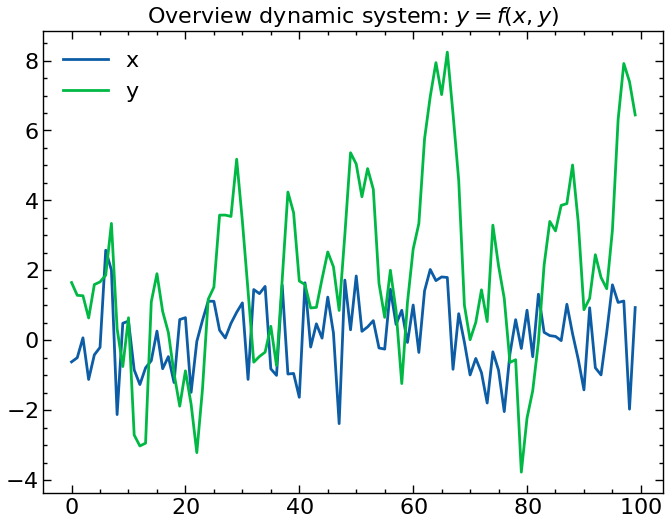

In [3]:
df.plot(title=r"Overview dynamic system: $y=f(x, y)$");

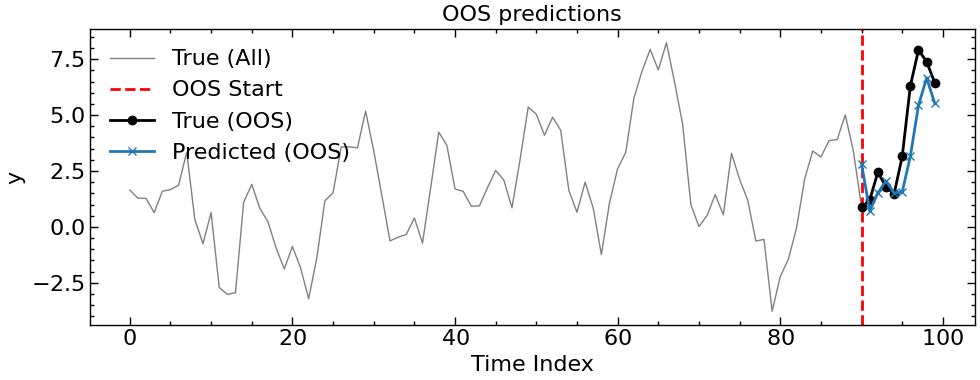

In [4]:
yhs = ols_estimator(df)
plot_preds(df, yhs)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from transformers import TimesFmModelForPrediction

# ── settings ───────────────────────────────────────────────────────────
MODEL_ID = "google/timesfm-2.0-500m-pytorch"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CONTEXT_LEN = 32

# df must exist and contain column "y"
# ----------------------------------------------------------------------
past = torch.tensor(
    df["y"].values[:-N_OOS][-CONTEXT_LEN:], dtype=torch.bfloat16, device=DEVICE
).unsqueeze(0)  # (1, T)
freq = torch.tensor([0], dtype=torch.long, device=DEVICE)

model = TimesFmModelForPrediction.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.bfloat16,
    attn_implementation="sdpa",
    device_map=DEVICE,
)
model.eval()

with torch.no_grad():
    out = model(
        past_values=past,
        freq=freq,
        forecast_context_len=CONTEXT_LEN,
        truncate_negative=False,
        return_dict=True,
    )

# ── extract statistics ────────────────────────────────────────────────
full = out.full_predictions[0, :, :N_OOS].float().cpu().numpy()  # (Q+1, H)

q_list = model.config.quantiles  #
idx_lo = q_list.index(0.1)
idx_med = q_list.index(0.5)
idx_hi = q_list.index(0.9)

mean_pred = full[0]
median_pred = full[1 + idx_med]
lower = full[1 + idx_lo]
upper = full[1 + idx_hi]

config.json:   0%|          | 0.00/692 [00:00<?, ?B/s]

ValueError: Using a `device_map`, `tp_plan`, `torch.device` context manager or setting `torch.set_default_device(device)` requires `accelerate`. You can install it with `pip install accelerate`

: 

In [ ]:
# ── plot ───────────────────────────────────────────────────────────────
hist = df["y"].values[:-N_OOS]
x_hist = np.arange(len(hist))
x_fore = np.arange(len(hist), len(hist) + N_OOS)
oos_start = df.index[-N_OOS]
plt.figure(figsize=(8, 4))
plt.plot(x_hist, hist, color="gray", label="history", linewidth=1)
plt.plot(x_fore, median_pred, label="median forecast")
plt.fill_between(x_fore, lower, upper, alpha=0.3, label="80 % PI")
plt.axvline(oos_start, color="red", linestyle="--", label="OOS Start")
plt.title("OOS predictions: TimesFM (uncalibrated quantiles)")
plt.legend()
plt.tight_layout()
plt.show()